In [1]:
#import all necessary libraries
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
# These are all possible positions scraped from Sofascore.
positions_list = ['GK', 'DL', 'DC', 'DR', 'DM', 'MC', 'AM', 'LW', 'RW', 'MR', 'ST', 'ML']

# Convert positions list to a dictionary for easier lookup
positions_dict = {position: i for i, position in enumerate(positions_list)}

In [3]:
# First I need to prepare the data so it reads the image files and their corresponding labels from directories.
# Then I need to encode the position labels into a suitable format for training the CNN.


#Define function to encode player positions into a binary format for model training
def encode_positions(positions):
    # Initialise a binary vector
    encoded = [0] * len(positions_dict)
    for position in positions:
        if position in positions_dict:
            encoded[positions_dict[position]] = 1
    return encoded

# Define function to load and preprocess the heatmap and position data
def load_data(images_dir, positions_dir):
    X = []  # heatmap data
    y = []  # encoded positions data
    for filename in os.listdir(images_dir):
        if filename.endswith(".png"):
            image_path = os.path.join(images_dir, filename)
            player_name = filename.split(".")[0]
            position_file = os.path.join(positions_dir, player_name + "_positions.txt")
            if not os.path.exists(position_file):
                continue  # Skip the heatmap if the positions file is not found

            # Load and preprocess the image
            image = Image.open(image_path).convert('RGB') #Heatmap data is in RGBA, lets convert to RGB.
            image = image.resize((280, 175))  # Resize the image (All heatmap images are 280x175px)
            image_array = np.array(image) # Convert the image to a numpy array for model processing
            X.append(image_array) # Append the image array to the list of images
            
            # Load and encode the positions
            with open(position_file, "r") as file:
                positions = file.read().splitlines()  # Adjusted to split on newlines
                encoded_positions = encode_positions(positions)
                y.append(encoded_positions)
    
    X = np.array(X)
    y = np.array(y)
    return X, y


# Define stored directories where heatmap and position data are stored
images_dir = "images"
positions_dir = "positions"
X, y = load_data(images_dir, positions_dir) #Call the load_data function above to process and load data

In [4]:
# Step 3: Split the data into train and validation sets. 20% of the data is for testing, 80% for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Normalise image data. This scales the pixel values between [0,1] when they are currently [0,255]
X_train = X_train / 255.0
X_test = X_test / 255.0

In [6]:
# Design CNN model architecture. Sequential model (linear stack of layers)
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(175, 280, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(positions_list), activation='sigmoid')  # Output layer
])

# Use ReLU activation to introduce non-linearity to the model.
# Sigmoid activation is used due to it being a multi-class problem (multiple positions to predict)

C:\Users\AmarL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [7]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 173, 278, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 86, 139, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 84, 137, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 42, 68, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 40, 66, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 168960)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      10,813,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,870,604 (41.47 MB)

 Trainable params: 10,870,604 (41.47 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

# Iterate across training dataset 10 times. Set aside 20% of the training data as validation dataset. 
# 'history' tracks records of loss values and metrtic values during training.

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 39s 749ms/step - accuracy: 0.3135 - loss: 0.4619 - val_accuracy: 0.5699 - val_loss: 0.1862
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 703ms/step - accuracy: 0.6237 - loss: 0.1683 - val_accuracy: 0.6263 - val_loss: 0.1670
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 705ms/step - accuracy: 0.6564 - loss: 0.1430 - val_accuracy: 0.6452 - val_loss: 0.1567
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 705ms/step - accuracy: 0.6493 - loss: 0.1360 - val_accuracy: 0.6586 - val_loss: 0.1633
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 698ms/step - accuracy: 0.6777 - loss: 0.1258 - val_accuracy: 0.6398 - val_loss: 0.1675
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 700ms/step - accuracy: 0.6802 - loss: 0.1137 - val_accuracy: 0.6263 - val_loss: 0.1593
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 711ms/step - accuracy: 0.6914 - loss: 0.0993 - val_accuracy: 0.6290 - val_loss: 0.1832
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 34s 717ms/step - accuracy: 0.7314 - loss: 0.0799 - val_accu

In [10]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.6073 - loss: 0.2952
Test Accuracy: 0.6043010950088501


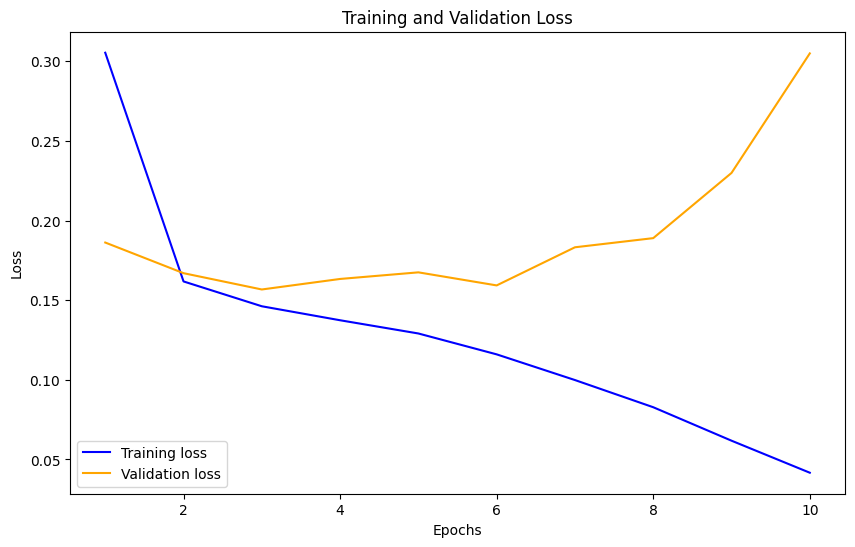

In [11]:
# Extracting loss and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting the training loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#It looks like the model begins to overfit around 7 epochs in?

In [12]:
# Now define function to preprocess a single image. We want this to predict unseen images to see if the model works.

def preprocess_image(image_path, target_size=(280, 175)):
    """Preprocess a single image for prediction."""
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size)
    image_array = np.array(image) / 255.0  # Normalise the image
    return np.expand_dims(image_array, axis=0)  # Expand dims to match the input shape for CNN


In [13]:
# Directory containing unseen images. Using the heatmap scrape code, I scraped PSV data.
unseen_image_dir = 'UnseenHeatmaps'

In [14]:
# Ensure the directory exists
if not os.path.isdir(unseen_image_dir):
    print(f"Directory '{unseen_image_dir}' not found.")
else:
    # Iterate over all PNG files in the directory
    for filename in os.listdir(unseen_image_dir):
        if filename.lower().endswith(".png"):
            player_name = filename.rsplit('.', 1)[0].replace('_', ' ').title()
            unseen_image_path = os.path.join(unseen_image_dir, filename)
            processed_image = preprocess_image(unseen_image_path)

            # Predict positions
            predictions = model.predict(processed_image)
            predicted_positions = (predictions > 0.5).astype(int)[0]

            # Translate predictions to position names
            predicted_position_names = [positions_list[i] for i, val in enumerate(predicted_positions) if val == 1]

            # Print the formatted statement
            if predicted_position_names:
                print(f"{player_name} is predicted to play in the following positions: {', '.join(predicted_position_names)}.")
            else:
                print(f"No positions were confidently predicted for {player_name}.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Andre Ramalho is predicted to play in the following positions: DC, DR.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Armando Obispo is predicted to play in the following positions: DC, MC.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Armel Bella Kotchap is predicted to play in the following positions: DC, DM, MC.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Boscagli Olivier is predicted to play in the following positions: DC.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
No positions were confidently predicted for Guus Til.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Hirving Lozano is predicted to play in the following positions: ST.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Isaac Babadi is predicted to play in the following positions: MC, AM.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Ismael Saibari is predicted to play in the following positions: MC, AM.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Jerdy Schouten is predicted to play in the following positions: DM, MC.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s